# Who Steals The Most In A Town Full Of Thieves?

Below is the analysis behind my strategy in the [2017-06-30 Riddler](https://fivethirtyeight.com/features/who-steals-the-most-in-a-town-full-of-thieves/). A quick recap of the rules:

> A town of 1,000 households has a strange law intended to prevent wealth-hoarding. On January 1 of every year, each household robs one other household, selected at random, moving all of that house’s money into their own house. The order in which the robberies take place is also random and is determined by a lottery. (Note that if House A robs House B first, and then C robs A, the houses of A and B would each be empty and C would have acquired the resources of both A and B.)

Two questions about this fateful day:

- What is the probability that a house is not robbed over the course of the day?
- Suppose that every house has the same amount of cash to begin with — say $100. Which position in the lottery has the most expected cash at the end of the day, and what is that amount?

## Part 1

This part is straightforward to solve. It's simply the probability of not getting robbed in a single round to the power of the number of rounds. Hence, if there are $n$ houses in the town, there will be $n-1$ chances to be robbed (you won't rob your own house). We get the probability of not being robbed as

$$
\left( \frac{n-2}{n-1} \right)^{n-1}
$$

for $n=1000$ we get $(998/999)^{999} \approx 0.3677$. What about the limit as the town grows?

$$
\lim_{n \to \infty} \left( \frac{n-2}{n-1} \right)^{n-1}
= \lim_{n \to \infty} \left( \frac{n-1}{n} \right)^n
= \frac{1}{e}.
$$

Surprisingly, the famous number $e$, Euler's constant, pops out!

## Part 2

This part is a little bit more tricky. First, note that you don't need to know anything about how the cash is distributed to compute the expected loot from your round. All you need to know is how much cash is out there and the number of houses. The amount of cash out there is just the total amount minus what ever is in your house before you perform your robbery, which is \$0 or \$100. After your round you will either get to keep your spoils or get zero if you're robbed.

We can express this in a tree:

```
                           / \
                          /   \
               1-p^(k-1) /     \  p^(k-1)
                        /       \
                       /         \
                      /           \             
Robbed before?      yes            no
                    /\    1-p^(n-k)/\
                   /  \           /  \ 
         1-p^(n-k)/    \p^(n-k)  /    \p^(n-k)
                 /      \       /      \
Robbed after?   yes     no     yes     no

Expected loot   $0   $Qn/(n-1) $0      $2Q
```

Here, $n$ is the total number of household and $k$ is your position in the lottery, $p = (n-2)/(n-1)$ is the probability of not getting robbed in one round. $\$Q$ is the amount of cash each household has before the day.

All we have to do now to calculate the expected loot $L_k$ of the household that draws number $k$ in the lottery is to take the sum of these expectancies weighted by the probability.

$$
L_k = \frac{n}{n-1}Q(1-p^{k-1})p^{n-k} + 2Qp^{k-1}p^{n-k}
    = Q\left[ \frac{n}{n-1} \left( \frac{n-2}{n-1} \right) ^{n-k} + \left( \frac{n-2}{n-1} \right) ^n \right].
$$

Since $\frac{n-2}{n-1} < 1$, $k=n$ is the best outcome of the lottery. This would give
$$
L_n = Q\left[ \frac{n}{n-1} + \left( \frac{n-2}{n-1} \right) ^n \right].
$$

In the current case with $Q=100$ and $n=1000$, we get $L_{1000} \approx 136.83$.

Similar to above, in the limit as the town grows, we have
$$
\lim_{n \to \infty} L_n = Q\left(1+\frac{1}{e}\right)
$$

We're essentially done, but let's finish off with a plot to visualize this.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

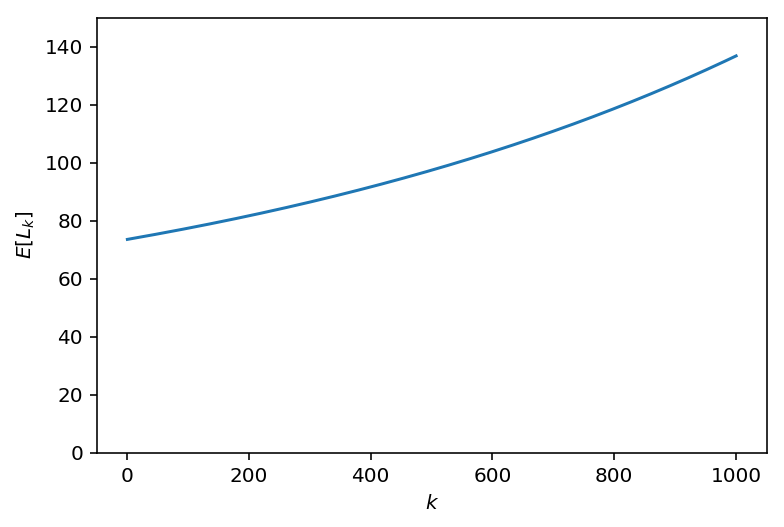

In [2]:
def plot_exp_loot(Q=100, n=1000, ax=None, **kwargs):
    k = np.arange(1, n+1)
    loot = Q * (n/(n-1)*((n-2)/(n-1))**(n-k) + ((n-2)/(n-1))**n)

    if ax is None:
        fig, ax = plt.subplots()

    ax.plot(k, loot, **kwargs)
    ax.set_ylim([0, 1.5*Q])
    ax.set_xlabel('$k$')
    ax.set_ylabel('$E[L_k]$')

    
Q = 100
n = 1000
plot_exp_loot(Q=Q, n=n)

## Extra Credit

How about the variance? Who is least likely to be broke at the end of the day? Figuring out the analytical solutions is beyond my patience today, but at least we can simulate a few thousand New Year's Days. I'll use Cython to accelerate my simulation, because I'm too lazy to vectorize the function. Cython gave about 50 times speedup of this function.

In [3]:
%load_ext Cython

In [4]:
%%cython

import numpy as np
cimport numpy as np
DTYPE = np.int64
ctypedef np.int64_t DTYPE_t

def simulate(int n_iter, int n_houses=1000, int Q=100):
    cdef np.ndarray[DTYPE_t, ndim=1] start = np.full(fill_value=Q, shape=n_houses, dtype=DTYPE)
    cdef np.ndarray[DTYPE_t, ndim=2] sims = np.zeros(shape=(n_houses, n_iter), dtype=DTYPE)
    cdef np.ndarray[DTYPE_t, ndim=1] robbed = np.zeros(shape=n_houses, dtype=DTYPE)
    cdef int i, j, r
    
    for j in range(n_iter):
        sims[:, j] = start
        robbed = np.random.randint(n_houses-1, size=n_houses, dtype=DTYPE)
        for i in range(n_houses):
            r = robbed[i]
            if r >= i:
                r += 1
            sims[i, j] += sims[r, j]
            sims[r, j] = 0
    return sims

Let's start with checking that our simulations agree with the analytic result we derived earlier.

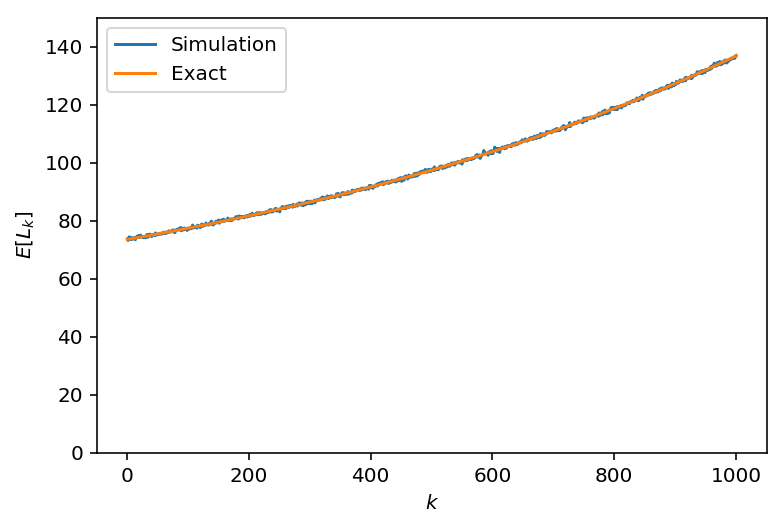

In [5]:
n_iter = 100000
sims = simulate(n_iter, n, Q)
fig, ax = plt.subplots()
ax.plot(np.arange(1, n+1), np.sum(sims, axis=1)/n_iter, label='Simulation')
plot_exp_loot(ax=ax, label='Exact')
ax.legend();

Next, let's look at the probability of being broke by the end of the day.

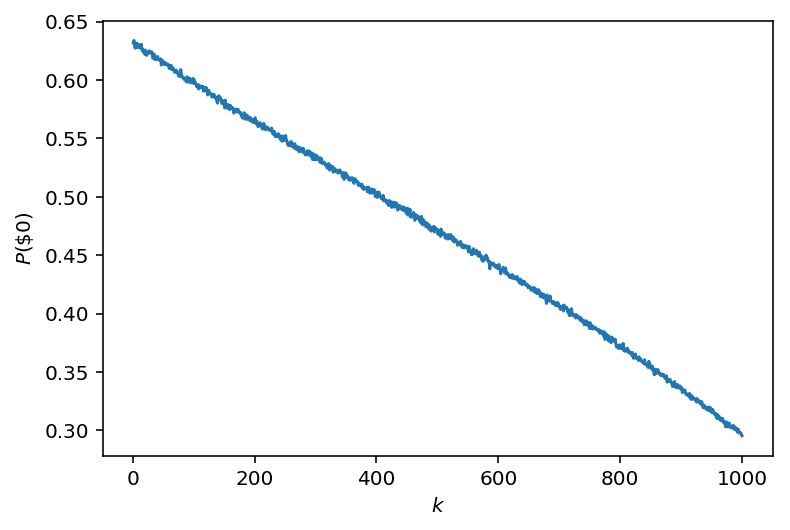

In [6]:
fig, ax = plt.subplots()
ax.plot(np.arange(1, n+1), np.sum(sims==0, axis=1)/n_iter, label='simulated')
ax.set_xlabel('$k$')
ax.set_ylabel('$P(\$0)$');

Finally, let's plot the probability of various outcomes given the position in the lottery. Those who start early tend to end the day with either $200 or $0 since the wealth distribution is still even when it's their turn.

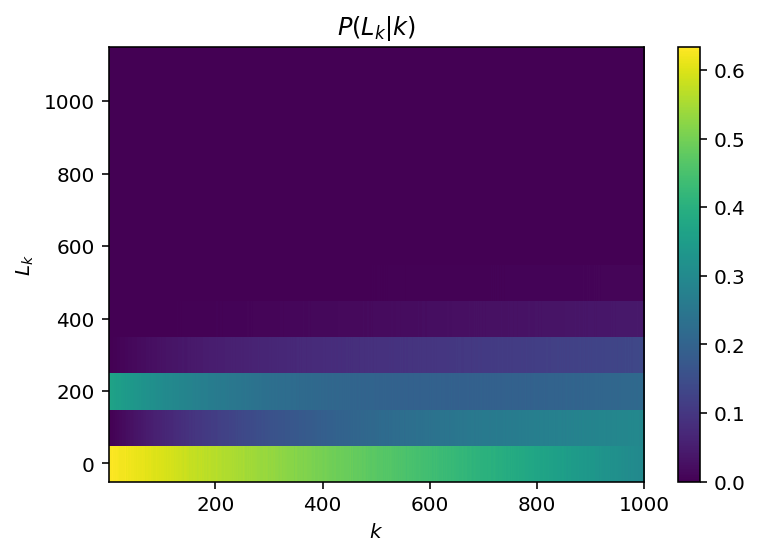

In [7]:
m = np.max(sims)
outcomes = np.zeros(shape=(m//Q+1, n))
for loot in range(0, m+1, Q):
    outcomes[loot//Q, :] = np.sum(sims==loot, axis=1)

fig, ax = plt.subplots()
image = ax.imshow(
    outcomes/n_iter,
    aspect='auto',
    origin='lower',
    extent=[1, n, -Q/2, m+Q/2],
)
ax.set_xlabel('$k$')
ax.set_ylabel('$L_k$')
ax.set_title('$P(L_k|k)$')
plt.colorbar(image, ax=ax);